In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pprint import pprint
import pyedflib

sys.path.append("..")
from sleeprnn.common import constants, pkeys, viz
from sleeprnn.data import utils
from nsrr import nsrr_utils
from figs_thesis import fig_utils

viz.notebook_full_width()
%matplotlib inline

# Observe NPZ files

In [2]:
dataset_name = 'cfs'
dataset_path = os.path.abspath(os.path.join(utils.PATH_DATA, 'nsrr', dataset_name, 'register_and_state'))
subject_files = os.listdir(dataset_path)
subject_files = [f for f in subject_files if '.npz' in f]
subject_files.sort()
print(subject_files)

['cfs-visit5-802467.npz']


dataset : cfs
subject_id : cfs-visit5-802467
channel : C3 minus M2
sampling_rate : 200
epoch_duration : 30.0
bandpass_filter : scipy.signal.butter, 0.1-35Hz, order 3
resampling_function : scipy.signal.resample_poly
original_sampling_rate : 128.0

Fraction of hypnogram in N2: 0.8082901554404145

Fraction of hypnogram in W: 0.14853195164075994


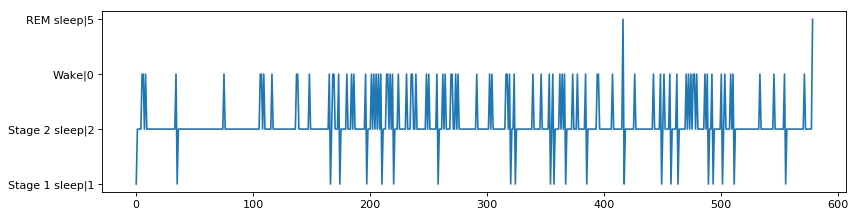


Fraction of NEW hypnogram in N2: 0.8082901554404145
New size as a fraction of original size: 1.0


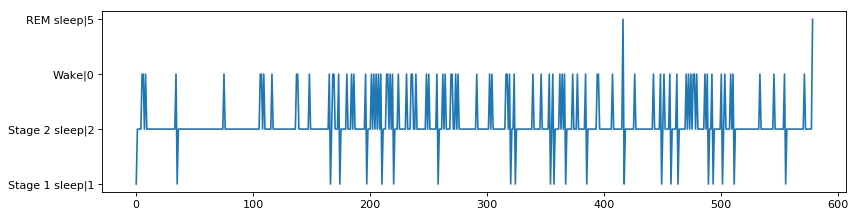

In [3]:
single_file = subject_files[0]

data_dict = np.load(os.path.join(dataset_path, single_file))

for key in ['dataset', 'subject_id', 'channel', 'sampling_rate', 'epoch_duration', 'bandpass_filter', 'resampling_function', 'original_sampling_rate']:
    print(key,":",data_dict[key])
    
signal = data_dict['signal']
hypnogram = data_dict['hypnogram']
fs = data_dict['sampling_rate']

n2_id = 'Stage 2 sleep|2'
w_id = 'Wake|0'
n2_fraction = np.mean(hypnogram == n2_id)
w_fraction = np.mean(hypnogram == w_id)
print("\nFraction of hypnogram in N2:", n2_fraction)
print("\nFraction of hypnogram in W:", w_fraction)

fig, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=80)
ax.plot(hypnogram)
plt.show()

# ignorar inicios y fines en etapa Wake|0 o ?
# mejor aun:only N2 como en cap, usando la segmentacion original de 30s
epoch_samples = int(30 * fs)
new_signal, new_hypnogram = nsrr_utils.short_signal_to_n2(signal, hypnogram, epoch_samples, n2_id)

n2_fraction = np.mean(new_hypnogram == n2_id)
print("\nFraction of NEW hypnogram in N2:", n2_fraction)
print("New size as a fraction of original size:", new_hypnogram.size / hypnogram.size)

fig, ax = plt.subplots(1, 1, figsize=(12, 3), dpi=80)
ax.plot(new_hypnogram)
plt.show()


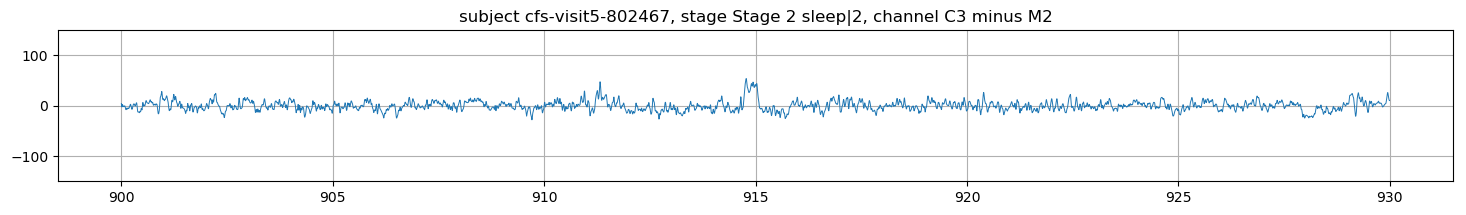

In [7]:
page_to_draw = 30 # 272

epoch_samples = int(data_dict['epoch_duration'] * fs)
start_sample = page_to_draw * epoch_samples
end_sample = start_sample + epoch_samples

segment_signal = signal[start_sample:end_sample]
# segment_signal = utils.apply_highpass(segment_signal, fs, 0.3)
stage = hypnogram[page_to_draw]
time_axis = np.arange(start_sample, end_sample) / fs

fig, ax = plt.subplots(1, 1, figsize=(18, 2), dpi=100)
ax.plot(time_axis, segment_signal, linewidth=0.7)
title_str = 'subject %s, stage %s, channel %s' % (data_dict['subject_id'], stage, data_dict['channel'])
ax.set_title(title_str)
ax.set_ylim([-150, 150])
ax.grid()
plt.show()

In [5]:
signal.std()

10.157311

In [ ]:
freq, power = utils.power_spectrum_by_sliding_window(segment_signal, fs, window_duration=5)
plt.plot(freq, power)
# plt.xlim([2, 50])
# plt.ylim([0, 0.002])
plt.show()

# Observe original EDF file

In [ ]:
dataset_name = 'chat1'
dataset_path = os.path.abspath(os.path.join(utils.PATH_DATA, dataset_name, 'originals'))
subject_files = os.listdir(dataset_path)
subject_files = [f for f in subject_files if '.edf' in f]
subject_files.sort()
print(subject_files)

In [ ]:
single_file = subject_files[0]

edf_filepath = os.path.join(dataset_path, single_file)
channels = [
    'REF X1',
    'E1',
    'E2',
    'C3',
    # 'C4',
    'O1',
    # 'O2',
    'M1',
    'M2' 
]
data_dict = {}
with pyedflib.EdfReader(edf_filepath) as file:
    channel_names = file.getSignalLabels()
    print("channels:")
    pprint(channel_names)
    for channel in channels:
        channel_to_extract = channel_names.index(channel)
        signal = 1e3 * file.readSignal(channel_to_extract)
        fs = file.samplefrequency(channel_to_extract)
        data_dict[channel] = signal.astype(np.float32)
new_channel = 'C3-M2'
data_dict[new_channel] = data_dict['C3'] - data_dict['M2']
channels.append(new_channel)

new_channel = 'M2_filt'
data_dict[new_channel] = utils.apply_lowpass(data_dict['M2'], fs=int(np.round(fs)), cutoff=20)
channels.append(new_channel)

new_channel = 'C3-M2filt'
data_dict[new_channel] = data_dict['C3'] - data_dict['M2_filt']
channels.append(new_channel)

In [ ]:
fs = int(np.round(fs))
page_duration = 30
page_size = int(page_duration * fs)
n_pages = data_dict[channels[0]].size / page_size
print("Total pages", n_pages)

In [ ]:
page_chosen = 400


start_sample = page_chosen * page_size
end_sample = start_sample + page_size
time_axis = np.arange(start_sample, end_sample) / fs
fig, axes = plt.subplots(len(channels), 1, figsize=(14, 1.5 * len(channels)), dpi=80, sharey=True)
for i, channel in enumerate(channels):
    ax = axes[i]
    ax.tick_params(labelsize=8)
    ax.plot(time_axis, data_dict[channel][start_sample:end_sample], linewidth=0.8, label=channel)
    ax.legend(loc="upper right", fontsize=8)
    
plt.tight_layout()
plt.show()

In [ ]:
freq, power = utils.power_spectrum_by_sliding_window(data_dict['M2'][start_sample:end_sample], 200, window_duration=5)
freq2, power2 = utils.power_spectrum_by_sliding_window(data_dict['E1'][start_sample:end_sample], 200, window_duration=5)
freq3, power3 = utils.power_spectrum_by_sliding_window(data_dict['M2_filt'][start_sample:end_sample], 200, window_duration=5)
plt.plot(freq, power)
plt.plot(freq2, power2)
plt.plot(freq3, power3)
plt.xlim([2, 50])
plt.ylim([0, 0.005])
plt.show()

In [ ]:
file = pyedflib.EdfReader(edf_filepath)

In [ ]:
file.